# Data pre-processing

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Utils](#utils)
- ### [Read `xarray.Dataset` from a `Zarr` file in Google Cloud bucket](#read_data)

<a id='libraries'></a>
## Python libraries

In [ ]:
from matplotlib import pyplot as plt
import time
import numpy as np
import scipy as sp
from scipy import interpolate
import pandas as pd
import geopandas as gpd
import LMIPy
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar
import regionmask
import zarr
import gcsfs
import requests
import shapely.wkb 

<a id='utils'></a>
### Utils
<a id='df_from_carto'></a>
**df_from_carto**

In [ ]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

**weighted_mean**

In [ ]:
def weighted_mean(df, columns=['cfr_raw'], weight_column='area', groupby_on='gid_2'):
    df = df.copy()
    
    # Define a lambda function to compute the weighted mean:
    wm = lambda x: np.average(x, weights=df.loc[x.index, weight_column])

    # Groupby and aggregate with lambda function:
    for n, column in enumerate(columns):
        if n == 0:
            df_new = df.groupby(groupby_on).agg({column: wm})  
        else:
            df_new[column] = df.groupby(groupby_on).agg({column: wm})[column]
        
    return gpd.GeoDataFrame(df_new)

**compute_score_category_label**

In [ ]:
def quantile_interp_function(s,q,y):
    """ Get a interpolated function based on quantiles.
    y and q should be the same length.
    
    Args:
        s(pandas Series): Input y data that needs to 
            be remapped.
        q(list): list with quantile x values.
        y(list): list with y value to map to.
        
    Returns:
        f(interp1d) : Scipy function object.
        quantiles(Pandas Series): list of quantile y 
            values. 
        
    Example:
    
        s = df["col"]
        q = [0,0.2,0.4,0.6,0.8,1]
        y = [0,1,2,3,4,5]
        f = quantile_interp_function(s,quantiles,y)
        y_new = f(x)
    
    """
    quantiles = s.quantile(q=q)
    print("quantiles used for aggregate total:",quantiles)
    f = interpolate.interp1d(quantiles,y)
    return f, quantiles

def score_to_category(score):
    if np.isnan(score):
        cat = np.nan
    elif score != 5:
        cat = int(np.floor(score))
    else:
        cat = 4
    return cat

def compute_score_category_label(df, columns, q, scores, labels_fun=None):
    df = df.copy()
    
    for column in columns:
        df.sort_values(column, inplace=True)
        
        # Geometries without a hazard are given the lowest risk score, 0
        df_0 = df[df[column] == 0]
        df_0[f"{column}_score"] = 0.
        
        df = df[df[column] != 0]
        s = df[column]
        f, quantiles =quantile_interp_function(s,q,scores)
        df[f"{column}_score"] = df[column].apply(f)
        
        df = pd.concat([df_0, df])
        
        # Add categories
        df[f"{column}_cat"] = df[f"{column}_score"].apply(score_to_category)
        
        # Add labels
        if labels_fun:
            df[f"{column}_label"] = df[f"{column}_cat"].apply(labels_fun)
            
    return df

**set_lat_lon_attrs**

In [ ]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [ ]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')

    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

## Raster vs Vector intersection
### Read `xarray.Dataset` from `TIFF` in GCS

In [7]:
file_names = {"Biodiversity Intactness": "bio.014_Biodiversity_Intactness.tif",
              "Terrestrial Human Footprint": "bio.015_Terrestrial_Human_Footprint_replacement.tif",
              "Earthquake Frequency and Distribution": "dis.004_Earthquake_Frequency_and_Distribution.tif",
              "Landslide Susceptibility": "dis.007_Landslide_Susceptibility_replacement.tif",
              "Volcano Frequency and Distribution": "dis.008_Volcano_Frequency_and_Distribution.tif"}

file_names = {"Landslide Susceptibility": "dis.007_Landslide_Susceptibility_replacement.tif",
              "Terrestrial Human Footprint": "bio.015_Terrestrial_Human_Footprint_replacement.tif"}

In [8]:
datasets = {}
base_url = 'https://storage.googleapis.com/us-resilience-map/datasets/'
for name, file_name in file_names.items():
    print(f"Read xarray.Dataset from {file_name}")
    url = f'{base_url}{file_name}'
    xda = xr.open_rasterio(url).squeeze().drop("band")
    
    # Replace all values equal to -9999 with np.nan
    xda = xda.where(xda != -9999.)
    
    # Rename coordinates 
    xda = xda.rename({'x': 'lon', 'y': 'lat'})
    
    # Convert the DataArray to a Dataset.
    ds = xda.to_dataset(name=name)
    
    datasets[name] = ds

Read xarray.Dataset from dis.007_Landslide_Susceptibility_replacement.tif
Read xarray.Dataset from bio.015_Terrestrial_Human_Footprint_replacement.tif


**Plot**

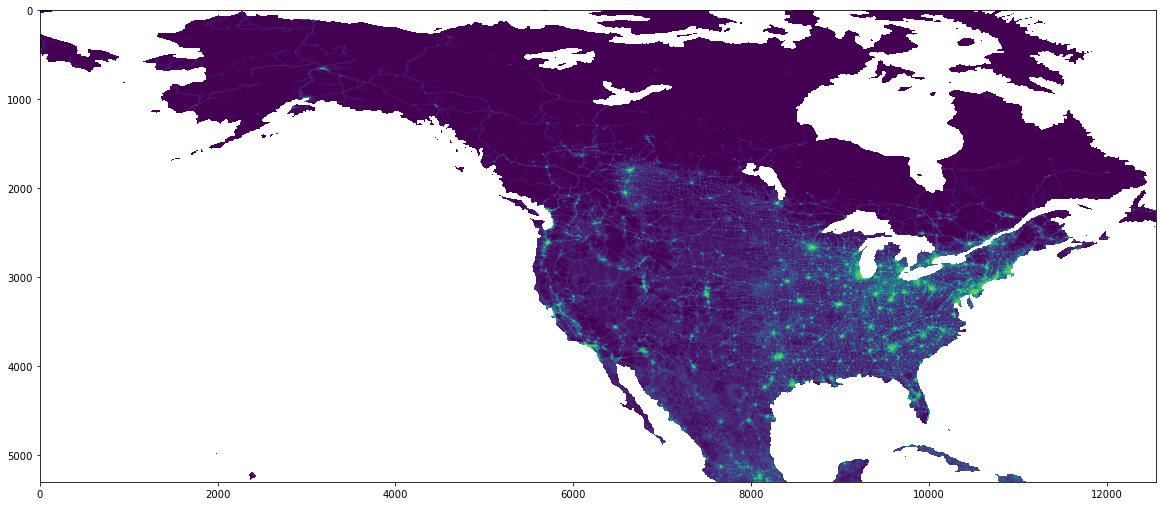

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(datasets['Terrestrial Human Footprint']['Terrestrial Human Footprint'].values)

### Read vector data
#### **State**

In [10]:
#account = 'wri-01'
#query = "SELECT iso, gid_0, name_0, gid_1, name_1, the_geom FROM gadm36_adm1 where iso = 'USA'"
#state = df_from_carto(account, query)
state = gpd.read_file('../data/gadm36_USA_shp/gadm36_USA_1.shp')
state.columns = map(str.lower, state.columns)
state = state[['gid_0', 'name_0', 'gid_1', 'name_1', 'geometry']]
state = state.reset_index(drop=True).reset_index()
state.head()

,index,gid_0,name_0,gid_1,name_1,geometry
0,0,USA,United States,USA.1_1,Alabama,"MULTIPOLYGON (((-87.97000 30.67667, -87.96972 ..."
1,1,USA,United States,USA.2_1,Alaska,"MULTIPOLYGON (((-179.13147 51.20972, -179.1322..."
2,2,USA,United States,USA.3_1,Arizona,"POLYGON ((-110.82376 31.33125, -110.82608 31.3..."
3,3,USA,United States,USA.4_1,Arkansas,"POLYGON ((-92.72461 33.01474, -92.86195 33.016..."
4,4,USA,United States,USA.5_1,California,"MULTIPOLYGON (((-118.58976 33.03865, -118.5897..."


**Plot**

(-180.0, -65.0)

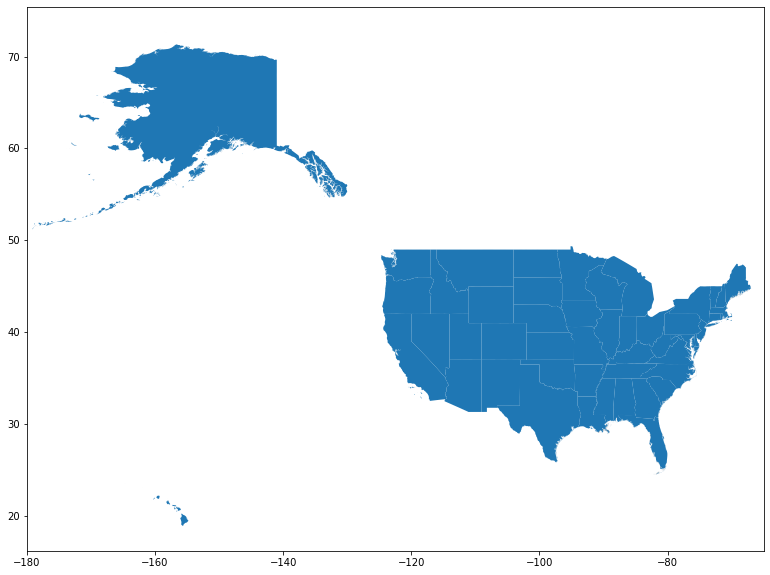

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
state.plot(ax=ax)
plt.xlim(-180, -65)

#### **County**

In [12]:
#account = 'wri-01'
#query = "SELECT iso, gid_0, name_0, gid_1, name_1, gid_2, name_2, hasc_2, the_geom FROM gadm36_adm2 where iso = 'USA'"
#county = df_from_carto(account, query)
county = gpd.read_file('../data/gadm36_USA_shp/gadm36_USA_2.shp')
county.columns = map(str.lower, county.columns)
county = county[['gid_0', 'name_0', 'gid_1', 'name_1', 'gid_2', 'name_2', 'geometry']]
county = county.reset_index(drop=True).reset_index()
county.head()

,index,gid_0,name_0,gid_1,name_1,gid_2,name_2,geometry
0,0,USA,United States,USA.1_1,Alabama,USA.1.1_1,Autauga,"POLYGON ((-86.81896 32.34027, -86.81084 32.347..."
1,1,USA,United States,USA.1_1,Alabama,USA.1.2_1,Baldwin,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ..."
2,2,USA,United States,USA.1_1,Alabama,USA.1.3_1,Barbour,"POLYGON ((-85.13026 31.76386, -85.13504 31.768..."
3,3,USA,United States,USA.1_1,Alabama,USA.1.4_1,Bibb,"POLYGON ((-87.42078 32.87446, -87.42028 32.971..."
4,4,USA,United States,USA.1_1,Alabama,USA.1.5_1,Blount,"POLYGON ((-86.95322 33.81542, -86.95449 33.845..."


**Plot**

(-180.0, -65.0)

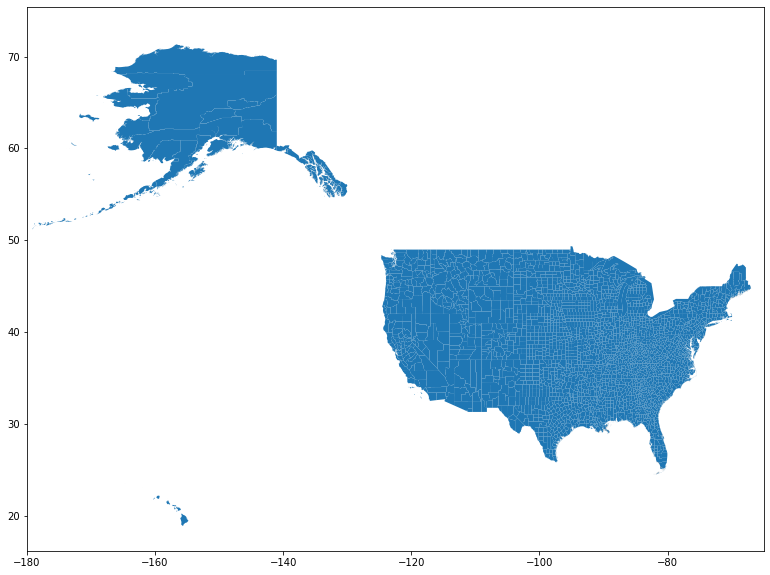

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
county.plot(ax=ax)
plt.xlim(-180, -65)

### Zonal statistics
**Create the data mask by rasterizing the vector data**

In [78]:
masks = {'state': state,
        'county': county}

for n, dataset in enumerate(datasets.items()):
    ds_name = dataset[0]
    ds = dataset[1]
    print(f"Creating data masks in {ds_name}")
    for mask_name, df in masks.items():
        print(f"Creating the data mask by rasterizing the vector data for {mask_name}")
        # Create the data mask by rasterizing the vector data
        ds[mask_name] = create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat')
        
        # Compute the mean value inside each geometry
        print(f"Computing the mean value inside each geometry")
        grouped_ds = ds.groupby(ds[mask_name])
        grid_mean = grouped_ds.mean()
        df_mean = grid_mean.to_dataframe()
        
        # Merge values with geometry GeoDataFrame
        if mask_name == 'state':
            if n == 0:
                df_tmp1 = pd.merge(df, df_mean[[ds_name]].reset_index().rename(columns={mask_name: 'index'}), on='index', how='left')
                df_tmp1['level'] = 1
                cols = df_tmp1.columns.tolist()
                df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]
            else:
                df_tmp1[ds_name] = list(df_mean[ds_name])
        else:
            if n == 0:
                df_tmp2 = pd.merge(df, df_mean[[ds_name]].reset_index().rename(columns={mask_name: 'index'}), on='index', how='left')
                df_tmp2['level'] = 2
                cols = df_tmp2.columns.tolist()
                df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]
            else:
                df_tmp2[ds_name] = list(df_mean[ds_name])
            
df_out = pd.concat([df_tmp1, df_tmp2])

Creating data masks in Landslide Susceptibility
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 6.9e-05 deg.

Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51


<ipython-input-6-de1edea2e9d1>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Number of ints in mask: 51
Computing the mean value inside each geometry
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 6.9e-05 deg.



<ipython-input-6-de1edea2e9d1>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 3148 potential geometries, of which 3148 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 3148
Number of geoms: 3148
Number of ints in mask: 3148
Computing the mean value inside each geometry
Creating data masks in Terrestrial Human Footprint
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 9.8e-05 deg.



<ipython-input-6-de1edea2e9d1>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51
Number of ints in mask: 51
Computing the mean value inside each geometry
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 9.8e-05 deg.



<ipython-input-6-de1edea2e9d1>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 3148 potential geometries, of which 3148 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 3148
Number of geoms: 3148
Number of ints in mask: 3148
Computing the mean value inside each geometry


In [80]:
df_out.head()

,level,index,gid_0,name_0,gid_1,name_1,geometry,Landslide Susceptibility,Terrestrial Human Footprint,gid_2,name_2
0,1,0.0,USA,United States,USA.1_1,Alabama,"MULTIPOLYGON (((-87.97000 30.67667, -87.96972 ...",1.780166,10.073434,NaN,NaN
1,1,1.0,USA,United States,USA.2_1,Alaska,"MULTIPOLYGON (((-179.13147 51.20972, -179.1322...",2.256733,0.495025,NaN,NaN
2,1,2.0,USA,United States,USA.3_1,Arizona,"POLYGON ((-110.82376 31.33125, -110.82608 31.3...",2.082394,4.949064,NaN,NaN
3,1,3.0,USA,United States,USA.4_1,Arkansas,"POLYGON ((-92.72461 33.01474, -92.86195 33.016...",1.684126,8.678571,NaN,NaN
4,1,4.0,USA,United States,USA.5_1,California,"MULTIPOLYGON (((-118.58976 33.03865, -118.5897...",2.723639,6.787177,NaN,NaN


**Plot**

(-180.0, -65.0)

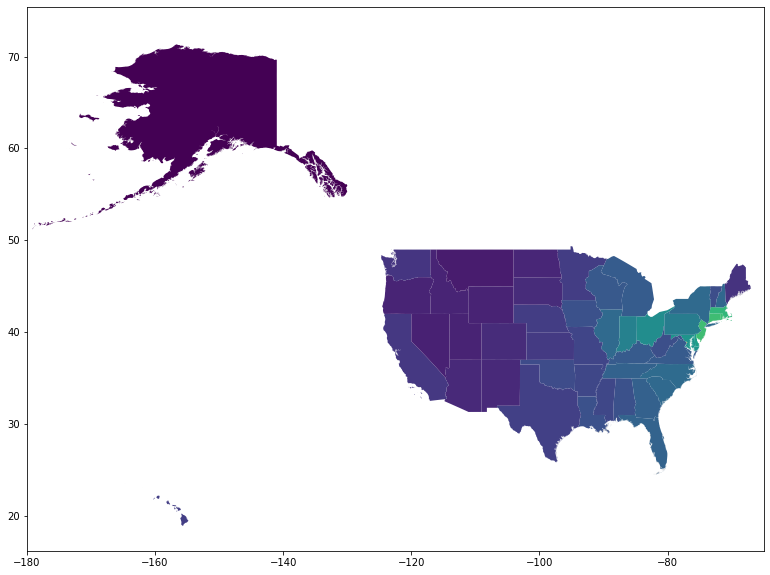

In [88]:
name = 'Terrestrial Human Footprint'
df = df_out[df_out['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax)
plt.xlim(-180, -65)

(-180.0, -65.0)

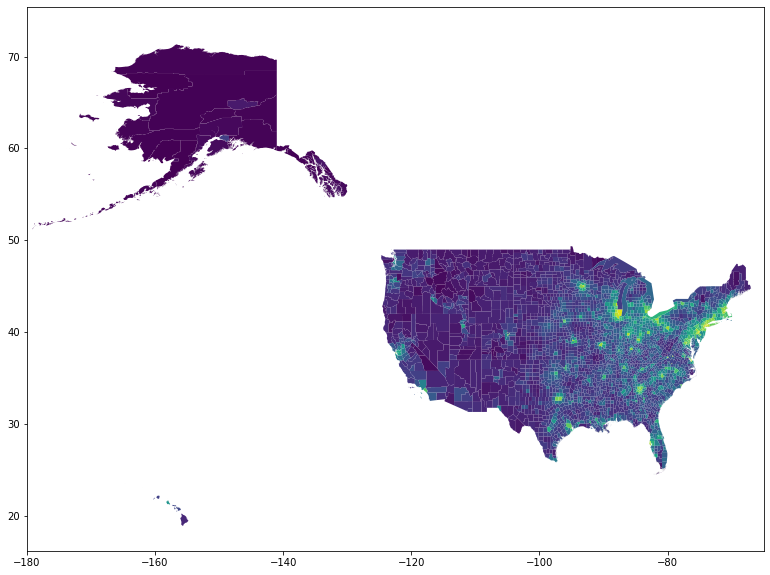

In [89]:
df = df_out[df_out['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax)
plt.xlim(-180, -65)

## Vector vs Vector intersection
### Read vector data
**Riverine flood risk**

In [90]:
ds = LMIPy.Dataset(id_hash='5152c286-53c1-4583-9519-816a6e41889d')
ds

Dataset 5152c286-53c1-4583-9519-816a6e41889d Annual indicator layers

In [106]:
account = 'wri-rw'
query = "SELECT s.aq30_id, s.gid_1, s.pfaf_id, s.string_id, s.cfr_label, s.cfr_cat, s.cfr_raw, s.cfr_score, s.rfr_label, s.rfr_cat, s.rfr_raw, s.rfr_score, r.the_geom \
FROM water_risk_indicators_annual_all s \
LEFT JOIN y2018m12d06_rh_master_shape_v01 r on s.aq30_id=r.aq30_id \
WHERE s.pfaf_id != -9999 and s.gid_1 != '-9999' and r.aqid != -9999 and  s.gid_1 like 'USA%'"
df_input = df_from_carto(account, query)
df_input = df_input[['rfr_raw', 'cfr_raw', 'geometry']]
df_input.head()

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,rfr_raw,cfr_raw,geometry
0,0.000145,0.000000,"MULTIPOLYGON (((-96.18414 32.28733, -96.20937 ..."
1,0.000000,0.000000,"MULTIPOLYGON (((-82.33572 44.53740, -82.34797 ..."
2,0.000495,0.000000,"MULTIPOLYGON (((-92.18487 37.98429, -92.19102 ..."
3,0.000498,0.000051,"MULTIPOLYGON (((-87.45862 30.30283, -87.46444 ..."
4,0.004233,0.000000,"MULTIPOLYGON (((-102.49568 38.12445, -102.6034..."


**Intersect geometries**

In [116]:
#Intersect geometries
df_tmp1 = gpd.overlay(state, df_input, how='intersection')
df_tmp1['level'] = 1
cols = df_tmp1.columns.tolist()
df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]

df_tmp2 = gpd.overlay(county, df_input, how='intersection')
df_tmp2['level'] = 2
cols = df_tmp2.columns.tolist()
df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]

df_out = pd.concat([df_tmp1, df_tmp2])

<ipython-input-116-370df457ff8d>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  df_tmp1 = gpd.overlay(state, df_input, how='intersection')
<ipython-input-116-370df457ff8d>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  df_tmp2 = gpd.overlay(county, df_input, how='intersection')


**Compute area of each geometry**

In [117]:
# Compute area of each geometry
df_out['area'] = df_out.area
df_out.head()

<ipython-input-117-ef08de7da52c>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_out['area'] = df_out.area


,level,index,gid_0,name_0,gid_1,name_1,rfr_raw,cfr_raw,geometry,gid_2,name_2,area
0,1,0.0,USA,United States,USA.1_1,Alabama,0.000035,0.0,"POLYGON ((-84.97490 32.38039, -84.97400 32.378...",NaN,NaN,2.397222e-07
1,1,10.0,USA,United States,USA.11_1,Georgia,0.000035,0.0,"POLYGON ((-84.97404 32.37863, -84.97400 32.378...",NaN,NaN,7.941152e-02
2,1,0.0,USA,United States,USA.1_1,Alabama,0.001172,0.0,"POLYGON ((-85.12865 31.00150, -85.17512 31.001...",NaN,NaN,3.040376e-06
3,1,9.0,USA,United States,USA.10_1,Florida,0.001172,0.0,"POLYGON ((-85.46325 30.99756, -85.37808 31.000...",NaN,NaN,1.641108e-01
4,1,0.0,USA,United States,USA.1_1,Alabama,0.000968,0.0,"POLYGON ((-85.09538 31.29335, -85.09538 31.293...",NaN,NaN,4.426762e-02


**Weighted mean**

In [118]:
# Weighted mean
df_tmp1 = weighted_mean(df_out[df_out['level'] == 1], columns=['rfr_raw', 'cfr_raw'], weight_column='area', groupby_on='gid_1')
# Merge with geometries
df_tmp1 = pd.merge(df_tmp1, state, on='gid_1', how='left')
df_tmp1['level'] = 1
cols = df_tmp1.columns.tolist()
df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]

# Weighted mean
df_tmp2 = weighted_mean(df_out[df_out['level'] == 2], columns=['rfr_raw', 'cfr_raw'], weight_column='area', groupby_on='gid_2')
# Merge with geometries
df_tmp2 = pd.merge(df_tmp2, county, on='gid_2', how='left')
df_tmp2['level'] = 2
cols = df_tmp2.columns.tolist()
df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]

df_out = pd.concat([df_tmp1, df_tmp2])

In [119]:
df_out.head()

,level,gid_1,rfr_raw,cfr_raw,index,gid_0,name_0,name_1,geometry,gid_2,name_2
0,1,USA.10_1,0.003214,0.000013,9.0,USA,United States,Florida,"MULTIPOLYGON (((-81.92486 24.53308, -81.92486 ...",NaN,NaN
1,1,USA.11_1,0.000779,0.000008,10.0,USA,United States,Georgia,"MULTIPOLYGON (((-81.45250 31.01778, -81.45139 ...",NaN,NaN
2,1,USA.13_1,0.002832,0.000000,12.0,USA,United States,Idaho,"POLYGON ((-111.04750 42.51359, -111.04769 42.4...",NaN,NaN
3,1,USA.14_1,0.000932,0.000000,13.0,USA,United States,Illinois,"POLYGON ((-89.31046 37.00681, -89.31493 37.010...",NaN,NaN
4,1,USA.15_1,0.000917,0.000000,14.0,USA,United States,Indiana,"POLYGON ((-85.79229 38.28737, -85.79288 38.286...",NaN,NaN


**Plot**

(-180.0, -65.0)

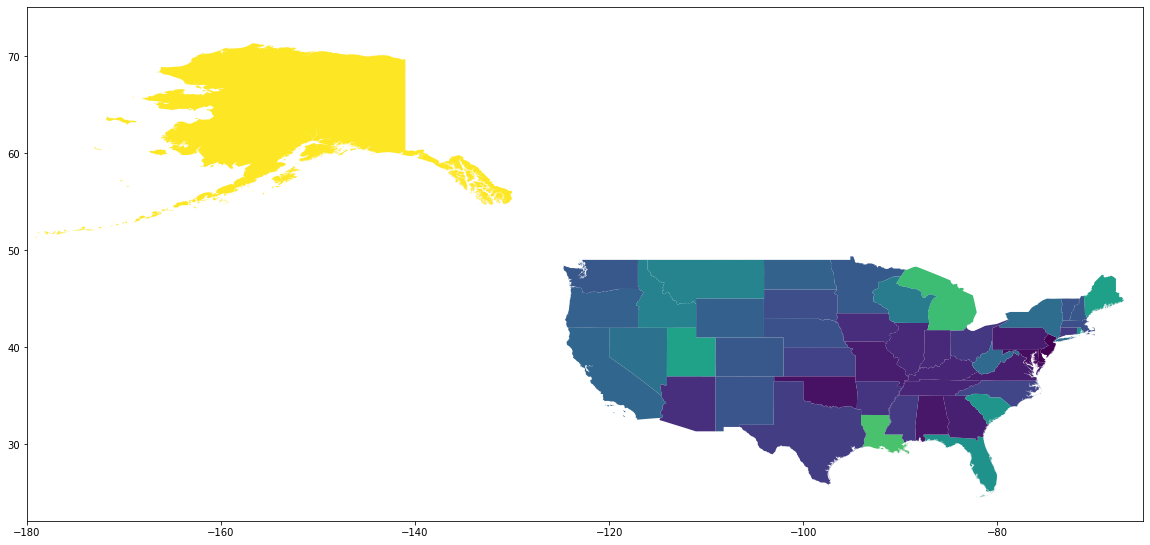

In [120]:
name = 'rfr_raw'
df = df_out[df_out['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax)
plt.xlim(-180, -65)

(-180.0, -65.0)

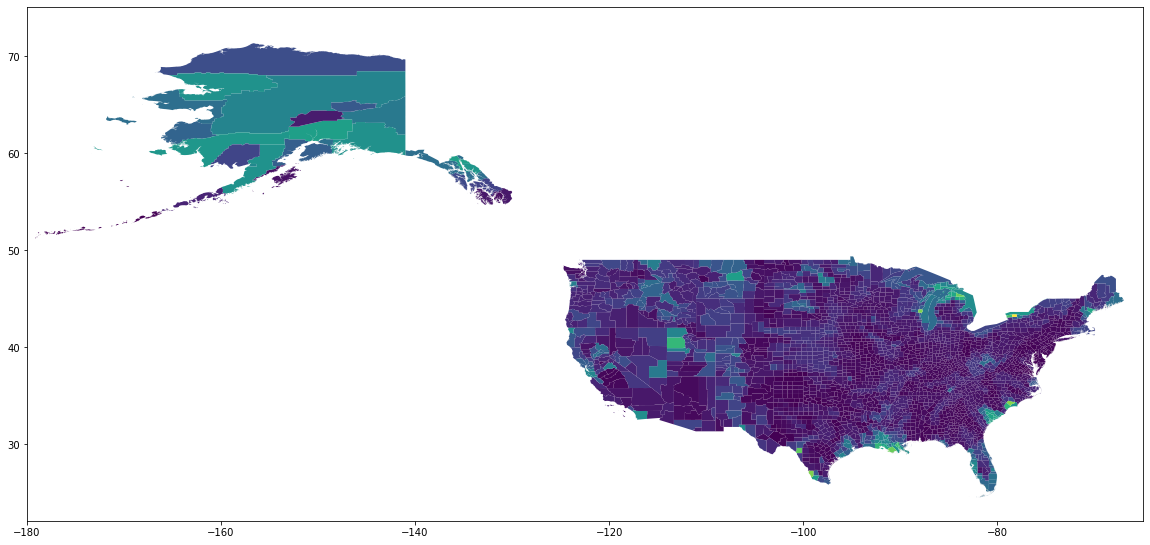

In [121]:
name = 'rfr_raw'
df = df_out[df_out['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax)
plt.xlim(-180, -65)

## Compute scores category and labels

In [122]:
def category_to_label(cat):
    if np.isnan(cat):
        label = "NoData"
    elif cat == 0:
        label = "Low (0-1)"
    elif cat == 1:
        label = "Low - Medium (1-2)"
    elif cat == 2:
        label = "Medium - High (2-3)"
    elif cat == 3:
        label = "High (3-4)"
    elif cat == 4: 
        label = "Extremely High (4-5)"
    else:
        label = "Error"
    return label

q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
df_new = compute_score_category_label(df_out[df_out['level'] == 2], columns=['rfr_raw'], q=q, scores=scores, labels_fun=category_to_label)

quantiles used for aggregate total: 0.0    0.000005
0.2    0.000422
0.4    0.000802
0.6    0.001279
0.8    0.002210
1.0    0.015805
Name: rfr_raw, dtype: float64


**Plot**

(-180.0, -65.0)

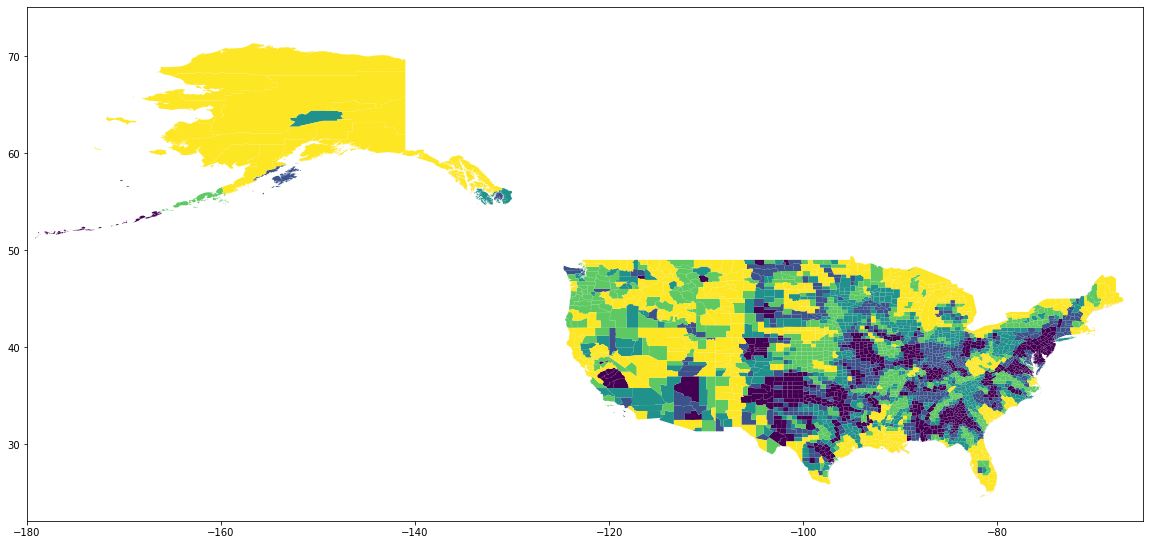

In [123]:
fig, ax = plt.subplots(figsize=(20, 10))
df_new.plot('rfr_raw_cat', ax=ax)
plt.xlim(-180, -65)